**Multi-Period Economic Dispatch model for power plants operated by Duke Energy + Solar & Biomass IPP in the Carolinas Region, Date: Dec 2, 2020**


In [ ]:
# Installing pyomo and 'cbc' solver
!pip install pyomo
!apt-get install -y -qq coinor-cbc
from pyomo.environ import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Reading the data
gen_data = pd.read_excel('Carolinas_ED(KVL)_Dem(Dec2_2020)_second.xlsx', sheet_name='Generation_Data')
load_data = pd.read_excel('Carolinas_ED(KVL)_Dem(Dec2_2020)_second.xlsx', sheet_name='Demand_Data')
reserves_data = pd.read_excel('Carolinas_ED(KVL)_Dem(Dec2_2020)_second.xlsx', sheet_name='Reserves_Data')
lines_data = pd.read_excel('Carolinas_ED(KVL)_Dem(Dec2_2020)_second.xlsx', sheet_name='Lines_Data')

In [ ]:
# Define the size of the sets
NumGens=len(gen_data)
NumNodes=len(load_data)
NumLines=len(lines_data)

#Just as a check, making sure we are having it good. 
print("We read data for", NumGens, "power generating units")
print("We read data for", NumNodes, "nodes")
print("We read data for", NumLines, "transmission lines")

We read data for 999 power generating units
We read data for 4 nodes
We read data for 4 transmission lines


In [ ]:
# Converting atttributes to numpy arrays
capacity = gen_data.loc[:, 'Capacity (MW)'].to_numpy()
cap_factor = gen_data.loc[:, 'Capacity factor'].to_numpy()
marginal_cost = gen_data.loc[:, 'Marginal Cost ($/MWh)'].to_numpy()
CO2_cost = gen_data.loc[:, 'CO2 emissions cost ($/MWh)'].to_numpy()
RampUp = gen_data.loc[:, 'Ramp Up (MW/h)'].to_numpy()
RampDown = gen_data.loc[:, 'Ramp Down (MW/h)'].to_numpy()
plant_name = gen_data.loc[:, 'Plant Name'].to_numpy()
GenNode = gen_data.loc[:,'Node'].to_numpy()
demand = load_data.iloc[:,2:len(load_data.columns)]
demand = demand.to_numpy()
reserves = reserves_data.iloc[:,2:len(load_data.columns)]
reserves = reserves.to_numpy()

In [ ]:
demand # Just as a check

array([[3441.18718719, 3471.1041041 , 3471.1041041 , 3407.80880881,
        3303.22322322, 3199.87387387, 3318.55255255, 3256.24624625,
        3234.73573574, 3248.08708709, 3291.10810811, 3398.41341341,
        3612.03503504],
       [  83.59159159,   84.31831832,   84.31831832,   82.78078078,
          80.24024024,   77.72972973,   80.61261261,   79.0990991 ,
          78.57657658,   78.9009009 ,   79.94594595,   82.55255255,
          87.74174174],
       [1017.03103103, 1025.87287287, 1025.87287287, 1007.16616617,
         976.25625626,  945.71171171,  980.78678679,  962.37237237,
         956.01501502,  959.96096096,  972.67567568, 1004.38938939,
        1067.52452452],
       [9376.19019019, 9457.7047047 , 9457.7047047 , 9285.24424424,
        9000.28028028, 8718.68468468, 9042.04804805, 8872.28228228,
        8813.67267267, 8850.05105105, 8967.27027027, 9259.64464464,
        9841.6986987 ]])

In [ ]:
reserves

array([[172.05935936, 173.55520521, 173.55520521, 170.39044044,
        165.16116116, 159.99369369, 165.92762763, 162.81231231,
        161.73678679, 162.40435435, 164.55540541, 169.92067067,
        180.60175175],
       [  4.17957958,   4.21591592,   4.21591592,   4.13903904,
          4.01201201,   3.88648649,   4.03063063,   3.95495495,
          3.92882883,   3.94504505,   3.9972973 ,   4.12762763,
          4.38708709],
       [ 50.85155155,  51.29364364,  51.29364364,  50.35830831,
         48.81281281,  47.28558559,  49.03933934,  48.11861862,
         47.80075075,  47.99804805,  48.63378378,  50.21946947,
         53.37622623],
       [468.80950951, 472.88523524, 472.88523524, 464.26221221,
        450.01401401, 435.93423423, 452.1024024 , 443.61411411,
        440.68363363, 442.50255255, 448.36351351, 462.98223223,
        492.08493493]])

In [ ]:
# Creating numpy arrays for number of generators, nodes, lines, and time periods. 
G=np.array([g for g in range(0,NumGens)]) 
N=np.array([n for n in range(0,NumNodes)])
L=np.array([l for l in range(0,NumLines)])
T=np.array([t for t in range(0,12)])
T1=np.array([t for t in range(1,12)]) # Adding this for ramping up and down constraints. 

In [ ]:
T #Just as a check

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [ ]:
T1 #Just as a check

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [ ]:
lines_data.columns #Just as a check

Index(['LineName', 'NodeFrom', 'NodeTo', 'Reactance (p.u)',
       'Line_Capacity (MW)'],
      dtype='object')

In [ ]:
# Declare the transmission lines' parameters and assign them the data we read before
NodeFrom=lines_data.loc[:,'NodeFrom'].to_numpy()
NodeTo=lines_data.loc[:,'NodeTo'].to_numpy()
LineCapacity=lines_data.loc[:,'Line_Capacity (MW)'].to_numpy()
LineReactance=lines_data.loc[:,'Reactance (p.u)'].to_numpy()

In [ ]:
LineReactance #Just as a check

array([0.1, 0.1, 0.1, 0.1])

In [ ]:
load_data.columns #Just as a check

Index(['LoadName', 'Node', '12/2/2020 7 p.m. EST', '12/2/2020 8 p.m. EST',
       '12/2/2020 9 p.m. EST', '12/2/2020 10 p.m. EST',
       '12/2/2020 11 p.m. EST', '12/3/2020 12 a.m. EST',
       '12/2/2020 12 a.m. EST', '12/2/2020 1 a.m. EST', '12/2/2020 2 a.m. EST',
       '12/2/2020 3 a.m. EST', '12/2/2020 4 a.m. EST', '12/2/2020 5 a.m. EST',
       '12/2/2020 6 a.m. EST'],
      dtype='object')

In [ ]:
##Declare the loads' parameters and assign them the data we read before
LoadBus=load_data.loc[:,'Node'].to_numpy()

In [ ]:
LoadBus #Just as a check

array([1, 2, 3, 4])

In [ ]:
#Define a function IndicatorMatrix that creates indicator matrices to relate generators with their node and lines with the nodes
#dataRows is a column vector of NumRows rows. Each element says the column where this row should be a one in the final matrix
def IndicatorMatrix(NumRows,NumCols,dataRows):
    matrix = np.zeros((NumRows,NumCols),dtype=int)
    for i in range(0,NumRows):
        matrix[i,int(dataRows[i]-1)]=1
    return matrix

In [ ]:
#Create indicator matrices using the function defined above
#GeneratorInBus is a matrix of G rows and N columns that has 1 in the position g,n if generator g is AT node N, 0 otherwise
GeneratorInBus=IndicatorMatrix(NumGens,NumNodes,GenNode)
#LineFromBus is an indicator matrix of L rows and N columns that has 1 in the position l,n if line l departs FROM node N, 0 otherwise
LineFromBus=IndicatorMatrix(NumLines,NumNodes,NodeFrom)
#LineToBus is an indicator matrix of L rows and N columns that has 1 in the position l,n if line l arrives TO node N, 0 otherwise
LineToBus=IndicatorMatrix(NumLines,NumNodes,NodeTo)

In [ ]:
LineToBus #Just as a check

array([[0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0]])

In [ ]:
from typing import MutableSet
#ED MODEL
def ED():
    m=ConcreteModel()
    m.dual = Suffix(direction=Suffix.IMPORT)#Create a 'dual' suffix component on the instance so the solver plugin will know which suffixes to collect
    m.N=Set(initialize=N)
    m.L=Set(initialize=L)
    m.G=Set(initialize=G)
    m.T=Set(initialize=T)
    m.T1=Set(initialize=T1)

    #Decision Variables
    m.p=Var(m.G, m.T, within=PositiveReals)#This is power generation. 
    m.flow=Var(m.L, m.T, bounds = (-100000,100000))#This is power flow on a line

    #Objective function
    m.system_cost=Objective(expr=sum(sum(m.p[g,t]*(marginal_cost[g]+CO2_cost[g]) for g in m.G) for t in m.T), sense=minimize)#Objective is to minimize costs (marginal + emissions)

    #Constraints
    # 1. Capacity Constraint:
    m.capacityconstraint = Constraint(m.G, m.T, rule=lambda m, g, t: m.p[g,t] <= capacity[g]*cap_factor[g]) 
    # 2. Nodal Constraint:
    m.NodePowerBalanceConstraint=Constraint(m.N, m.T, rule=lambda m, n, t: sum(LineToBus[l,n]*m.flow[l,t] for l in L)
    -sum(LineFromBus[l,n]*m.flow[l,t] for l in L)+sum(GeneratorInBus[g,n]*m.p[g,t] for g in G) == demand[n,t])
    # 3. Kirchoff's equation: 
    m.KVLAroundLoopConstraint=Constraint(m.T, rule=lambda m, t: sum(LineReactance[l]*m.flow[l,t] for l in L)==0)
    # 4. Power flow in a line Constraint:
    m.MaxFlow=Constraint(m.L, m.T, rule=lambda m, l, t:  m.flow[l,t] <= LineCapacity[l])
    # 5. Counter Power flow in a line Constraint:
    m.MaxCounterFlow=Constraint(m.L, m.T, rule=lambda m, l, t:  m.flow[l,t] >= -LineCapacity[l])
    # 6. Ramping Up constraint
    m.RampingUp=Constraint(m.G, m.T1, rule=lambda m, g, t1: m.p[g,t1] - m.p[g,t1-1]<= RampUp[g])
    # 7. Ramping Down constraint
    m.RampingDown=Constraint(m.G, m.T1, rule=lambda m, g, t1: m.p[g,t1-1] - m.p[g,t1]<= RampDown[g])

    return m

In [ ]:
m = ED()
SolverFactory('cbc', executable='/usr/bin/cbc').solve(m).write() # Solving the model

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 4184682.189
  Upper bound: 4184682.189
  Number of objectives: 1
  Number of constraints: 34123
  Number of variables: 12037
  Number of nonzeros: 809
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.25
  Wallclock time: 0.25
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: None
   

In [ ]:
# Printing the solution
print('SOLUTION')
print('The total system cost is = $',m.system_cost())
print('Commitment and Generation')
for t in T:
 print('At time = '+((str(t+7)+str(" PM")) if t<5 else((str("12 AM"))) if t==5 else (str(t-5)+str(" AM"))))  
 for g in G:
  print('Plant Name: '+plant_name[g]+','+' Power: '+str(m.p[g,t]()))

Streaming output truncated to the last 5000 lines.
At time = 2 AM
Plant Name: Brunswick Nuclear Plant – Brunswick County, NC, Power: 1713.1366
Plant Name: Catawba Nuclear Station – York County, SC, Power: 2209.6714
Plant Name: Harris Nuclear Plant – Wake County, NC, Power: 957.734
Plant Name: McGuire Nuclear Station – Mecklenburg County, NC, Power: 126.72189
Plant Name: Oconee Nuclear Station – Seneca, SC, Power: 2459.1507
Plant Name: Robinson Nuclear Plant – Darlington County, SC, Power: 699.15623
Plant Name: Bear Creek Hydro Station – Tuckasegee, NC, Power: 3.8781
Plant Name: Blewett Falls Hydro Station – Lilesville, NC, Power: 12.5
Plant Name: Bridgewater Hydro Station – Glen Alpine, NC, Power: 13.158495
Plant Name: Cedar Cliff Hydro Station – Tuckasegee, NC, Power: 1.5366
Plant Name: Cedar Creek Hydro Station – Rocky Creek, SC, Power: 13.8544
Plant Name: Cowans Ford Hydro Station – Mecklenburg County, NC, Power: 175.0
Plant Name: Dearborn Hydro Station – Great Falls, SC, Power: 19.

In [ ]:
# From this part on, it's about creating excel files for the putput we got. 
sheet_number = 0
workbook = []
for sheet_number in T:
  generation_out = pd.DataFrame(gen_data['Plant Name'])
  generation_out = generation_out.assign(Plant_Type = gen_data['Plant Type'], Capacity = gen_data['Capacity (MW)'], CF = gen_data['Capacity factor'])
  for g in G:
   generation_out.at[g,str("Generation")] = value(m.p[g,sheet_number])
  workbook.append(generation_out)

In [ ]:
T #Just as a check

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [ ]:
len(workbook) #Just as a check

12

In [ ]:
final = workbook
sheet = ['7 PM', '8 PM', '9 PM','10 PM','11 PM','12 AM','1 AM','2 AM','3 AM','4 AM','5 AM', '6 AM']

write = pd.ExcelWriter('Carolinas_Gen_output_Dec2_2020_7PM_6AM.xlsx') #This is the first excel file created - has generation at all times in seperate sheets. 
for i,df in enumerate(final, 0):
  df.to_excel(write, sheet_name= '%s' %sheet[i], index=False)    
write.save()

In [ ]:
# Creating a data frame for LMP at node n at time t
price = []
time = []
LMP = pd.DataFrame(load_data["Node"])
for t in T:
  for n in N:
    LMP.at[n, ((str(t+7)+str(" PM")) if t<5 else((str("12 AM"))) if t==5 else (str(t-5)+str(" AM")))] = value(m.dual[m.NodePowerBalanceConstraint[n,t]])
    time.append(((str(t+7)+str(" PM")) if t<5 else((str("12 AM"))) if t==5 else (str(t-5)+str(" AM"))))
    price.append(value(m.dual[m.NodePowerBalanceConstraint[n,t]]))

# Creating data frame for power flow on line l at time t
flow_output = pd.DataFrame(lines_data["LineName"])
for t in T:
  for l in L:
   flow_output.at[l, ((str(t+7)+str(" PM")) if t<5 else((str("12 AM"))) if t==5 else (str(t-5)+str(" AM")))] = value(m.flow[l,t])

In [ ]:
LMP

,Node,7 PM,8 PM,9 PM,10 PM,11 PM,12 AM,1 AM,2 AM,3 AM,4 AM,5 AM,6 AM
0,1,11.963429,11.963429,11.963429,11.963429,11.963429,11.963429,11.963429,11.963429,11.963429,11.963429,11.963429,11.963429
1,2,34.275832,34.275832,34.275832,34.275832,32.237083,31.883848,32.237083,31.883848,31.883848,31.883848,32.237083,34.275832
2,3,56.588235,56.588235,56.588235,56.588235,52.510736,51.804268,52.510736,51.804268,51.804268,51.804268,52.510736,56.588235
3,4,78.900638,78.900638,78.900638,78.900638,72.784390,71.724688,72.784390,71.724688,71.724688,71.724688,72.784390,78.900638


In [ ]:
node_1 = []
node_2 = []
node_3 = []
node_4 = []
for t in T: 
  node_1.append(value(m.dual[m.NodePowerBalanceConstraint[0,t]]))
  node_2.append(value(m.dual[m.NodePowerBalanceConstraint[1,t]]))
  node_3.append(value(m.dual[m.NodePowerBalanceConstraint[2,t]]))
  node_4.append(value(m.dual[m.NodePowerBalanceConstraint[3,t]]))

In [ ]:
sheet

['7 PM',
 '8 PM',
 '9 PM',
 '10 PM',
 '11 PM',
 '12 AM',
 '1 AM',
 '2 AM',
 '3 AM',
 '4 AM',
 '5 AM',
 '6 AM']

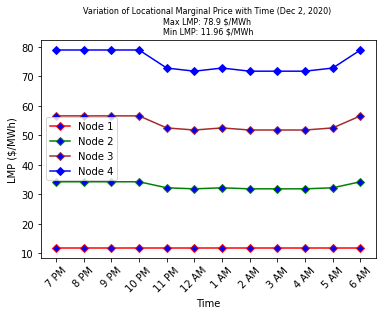

In [ ]:
# Plotting LMP against Time to see variation. 
# This was done as a curiousity exercise. The output is a PDF doc created that has this plot in a greenyellow background for better visualization and appeal. 
plt.plot(sheet, node_1, color = 'red', marker = 'D', markerfacecolor='blue')
plt.plot(sheet, node_2, color = 'green', marker = 'D', markerfacecolor='blue')
plt.plot(sheet, node_3, color = 'brown', marker = 'D', markerfacecolor='blue')
plt.plot(sheet, node_4, color = 'blue', marker = 'D', markerfacecolor='blue')
plt.xlabel("Time")
plt.xticks(rotation = 45)
plt.ylabel("LMP ($/MWh)")
plt.gca().legend(('Node 1','Node 2', 'Node 3', 'Node 4'))
par = {'axes.titlesize':8}
plt.rcParams.update(par)
plt.title("Variation of Locational Marginal Price with Time (Dec 2, 2020) \n"+"Max LMP: "+str(round(max(price),2))+" $/MWh \n"+"Min LMP: "+str(round(min(price),2))+" $/MWh")
plt.savefig('LMP(Dec 2, 2020)_7PM_6AM.pdf', facecolor='greenyellow', transparent=True)

In [ ]:
final2 = [flow_output, LMP]
sheet2 = ['Flow', 'LMP']

write1 = pd.ExcelWriter('Carolinas_Price & Flow_output_Dec2_2020_7PM_6AM.xlsx') # This is the 2nd excel output file created - has power flows in the lines and LMP in 2 sheets. 
for i,df in enumerate(final2, 0):
    df.to_excel(write1, sheet_name= '%s' %sheet2[i], index=False)    
write1.save()